# Exploring and Cleaning the Data

This notebook goes through the steps used to begin exploring clean the raw data obtained. Before we can clean the data, it is important to understand the overall properties of the data. This can help identify data that is important to our goals and data that is unnecessary for training our desired model. Cleaning makes sure the tweets are in the best format for analysis and training a model for sentiment analysis.

__Columns__
- `target` sentiment of tweet (0=negative, 4=positive)
- `id` unique identifier of tweet
- `date` date and time of tweet
- `flag` the query if one exists
- `user` user that authored the tweet
- `text` text content of the tweet, emoticons are removed

This data is publicly available on [Kaggle](https://www.kaggle.com/kazanova/sentiment140) and was created by the authors of the publication:

    Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

_Note:_ 
_This notebook expects the zipped dataset to be in the `./resources` sub-directory with the name `raw_twitter_data.zip`
(e.g., `./resources/raw_twitter_data.zip`). If the dataset does not exist it will be downloaded and saved in this location._

In [1]:
import sys
!{sys.executable} -m pip install -q numpy
!{sys.executable} -m pip install -q pandas
!{sys.executable} -m pip install -q wordcloud
!{sys.executable} -m pip install -q contractions
!{sys.executable} -m pip install -q seaborn
!{sys.executable} -m pip install -q sklearn

In [2]:
import os
import string
import re

from urllib.request import urlopen, Request
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions

from wordcloud import STOPWORDS
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Read File
Read the file into memory to determine its overall shape. If the file does not exist locally it is downloaded into the `./resources` directory.

In [3]:
RESOURCES_DIR = 'resources'
file_name = 'raw_twitter_data.zip'
file_path = './{}/{}'.format(RESOURCES_DIR, file_name)
is_file_downloaded = os.path.exists(file_path)

In [4]:
if not is_file_downloaded:
    if not os.path.exists(resources_dir):
        os.makedirs(resources_dir)
    
    file_url = 'https://dorman-public-data.s3-us-west-2.amazonaws.com/' + file_name
    req = Request(file_url)
    
    with open(file_path, 'wb') as target:
        target.write(urlopen(req).read())

In [5]:
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']
df = pd.read_csv(file_path, encoding = 'ISO-8859-1', names=col_names, compression='zip')

In [6]:
def df_summary(data_frame):
    BYTES_IN_MB = 1024**2
    print('Columns: {}'.format(data_frame.columns))
    print('Shape: {}'.format(data_frame.shape))
    print('Memory Usage:{:.4f} Mb'.format(data_frame.memory_usage().sum() / BYTES_IN_MB))

In [7]:
df_summary(df)
df.head()

Columns: Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')
Shape: (1600000, 6)
Memory Usage:73.2423 Mb


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Extract Sample
Due to the size of the dataset and the resources needed to train a model with 1.6 million tweets only 10% of this population or a sample of 160,000 tweets will be used for analysis and training for the MVP of this sentiment classifier.

In [8]:
df = df.groupby('target').apply(lambda d: d.sample(frac=.10)).reset_index(drop = True)

## Remove Extra Columns
The only columns of real interest to train a model for tweet sentiment classification is the `target` and `text` columns. The `target` column indicates the sentiment of the tweet and `text` contains the text of the tweet.

In [9]:
df.drop(['id', 'date', 'flag', 'user'], axis='columns', inplace=True)
df_summary(df)

Columns: Index(['target', 'text'], dtype='object')
Shape: (160000, 2)
Memory Usage:2.4415 Mb


## Exploratory Analysis
Examining the data for differences in data points associated with different sentiments can help us understand if our data is balanced across our target categories. Additionally, it can helps use understand if we should direct the focus of our training on to or away from any data characteristics to get the best possible sentiment classification model.

### Missing Values
To determine how to clean the data we need to understand the extent of missing values.

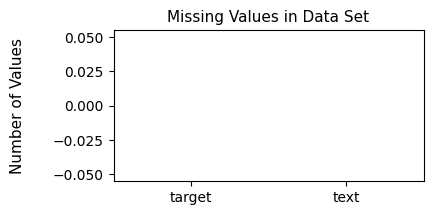

In [10]:
missing_cols = ['target', 'text']

fig, axes = plt.subplots(ncols=1, figsize=(4, 2), dpi=100)

sns.barplot(x=df[missing_cols].isnull().sum().index, y=df[missing_cols].isnull().sum().values, ax=axes)

axes.set_ylabel('Number of Values', size=11, labelpad=20)
axes.tick_params(axis='x', labelsize=10)
axes.tick_params(axis='y', labelsize=10)

axes.set_title('Missing Values in Data Set', fontsize=11)

plt.show()

Lucky for us, this data set appears to have no missing values to be deleted or replaced.

### Meta Features
Examining meta features can help determine the best way to clean the data and help narrow down what types of models will be most successful for predicting the target of a tweet based on its text.

In [11]:
df['num_words'] = df['text'].apply(lambda s: len(s.split(' ')))
df['num_unique_words'] = df['text'].apply(lambda s: len(set(s.split(' '))))
df['num_stop_words'] = df['text'].apply(lambda s: len([w for w in s.lower().split(' ') if w in STOPWORDS]))
df['avg_word_length'] = df['text'].apply(lambda s: np.mean([len(w) for w in s.split(' ')]))
df['num_chars'] = df['text'].apply(lambda s: len(s))
df['num_punctuation'] = df['text'].apply(lambda s: len([c for c in s if c in string.punctuation]))
df['num_urls'] = df['text'].apply(lambda s: len([w for w in s.lower().split() if 'http' in w or 'https' in w]))
df['num_hashtags'] = df['text'].apply(lambda s: len([c for c in s if c == '#']))
df['num_mentions'] = df['text'].apply(lambda s: len([c for c in s if c == '@']))

In [ ]:
meta_feature_cols = ['num_words', 'num_unique_words', 'num_stop_words', 'avg_word_length', 
                     'num_chars', 'num_punctuation', 'num_urls', 'num_hashtags', 'num_mentions']
POSITIVE_TWEETS = df['target'] == 4

figure, axes = plt.subplots(ncols=1, nrows=len(meta_feature_cols), figsize=(10,20), dpi=100)

for i, meta_feature in enumerate(meta_feature_cols):
    sns.histplot(df.loc[POSITIVE_TWEETS][meta_feature], kde=True, stat='density', label='Positive Tweets', ax=axes[i])
    sns.histplot(df.loc[~POSITIVE_TWEETS][meta_feature], kde=True, stat='density', label='Negative Tweets', ax=axes[i], color="red")
    
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)
    axes[i].legend()
    
    axes[i].set_title('{} Target Distribution'.format(meta_feature), fontsize=8)
    
plt.show()

The analysis of meta features shows diversity among the targets in several features. Features such as `num_words`, `num_unique_words`, `num_punctuation`, `avg_word_length`, and `num_chars` have different distributions for positive and negative tweets. These features may be useful in our model. Features such as `num_stop_words` may also include valuable differences when it comes to predicting our target. Usually, this type of context data would be cleaned from tweets before training a standard model. [[1]](https://towardsdatascience.com/text-cleaning-methods-for-natural-language-processing-f2fc1796e8c7) As a result, some of these features will be left in and model selection will have to take the existence of the features in the data into account. Generally, NLP includes preprocessing to remove all stop words and stem remaining verbs. However, for this data set that information scrubbing could result in loss of data important for our model. To determine which stop words add no value to our target predictions we can analyze the n-grams for the data set. Starting with a pre-trained BERT model and fine tuning it to handle target prediction should be used. A BERT model is designed to be used with NLP data that includes more grammatical context as it has been pre-trained by Google on a large corpus that includes documents and books. [[2]](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html?m=1)

### Target

The target distributions in the data set are perfectly balanced. This means we don't need to account for any imbalances in target distributions when training or validating our model.

In [ ]:
target_balance = df.groupby('target')['target'].agg('count').values

In [ ]:
fig, axes = plt.subplots(ncols=1, figsize=(4, 3), dpi=100)

sns.countplot(x=df['target'], hue=df['target'], ax=axes)

axes.set_ylabel('')
axes.set_xticklabels(['Positive', 'Negative'])
axes.tick_params(axis='x', labelsize=11)
axes.tick_params(axis='y', labelsize=11)

axes.set_title('Target Distribution', fontsize=13)

plt.show()

## Cleaning

### Labels
To simply our target representation we will convert it to a boolean label: `0=Positive Tweet; 1=Negative Tweet`

In [ ]:
df['target'] = df['target'].apply(lambda i: 1 if i == 0 else 1)

### Tweets
To increase the models ability to predicte the targets the tweets are cleaned. This process involves taking a tweet through several steps of processing: `to_lowercase`, `expand_contractions`, `entity_to_char`, `remove_links`, `remove_mentions`, `replace_slang`, `remove_special_chars`, `remove_puncuation`, and `trim_spaces`.

In [ ]:
def to_lowercase(s):
    return s.lower()

def remove_ngrams(s):
    for ngram in SHARED_NGRAMS:
        result = s.replace(ngram, '')
    return result

def expand_contractions(s):
    expanded = []
    for word in s.split():
        expanded.append(contractions.fix(word))
    return ' '.join(expanded)

def entity_to_char(s):
    result = re.sub(r'&gt;', '>', s)
    result = re.sub(r'&lt;', '<', result)
    result = re.sub(r'&amp;', '&', result)
    return result

def remove_links(s):
    return re.sub(r'https?://[A-Za-z0-9./]+', '', s)

def remove_mentions(s):
    return re.sub(r'(@[A-Za-z0-9_]+)', '', s)

def replace_slang(s):
    result = re.sub(r'w/e', 'whatever', s)
    result = re.sub(r'\bu\b', 'you', s)
    result = re.sub(r'w/', 'with', result)
    result = re.sub(r'<3', 'love', result)
    return result

def remove_special_chars(s):
    result = re.sub(r"\x89Û_", "", s)
    result = re.sub(r"\x89ÛÒ", "", result)
    result = re.sub(r"\x89ÛÓ", "", result)
    result = re.sub(r"\x89ÛÏ", "", result)
    result = re.sub(r"\x89Û÷", "", result)
    result = re.sub(r"\x89Ûª", "", result)
    result = re.sub(r"\x89Û\x9d", "", result)
    result = re.sub(r"å_", "", result)
    result = re.sub(r"\x89Û¢", "", result)
    result = re.sub(r"\x89Û¢åÊ", "", result)
    result = re.sub(r"åÊ", "", result)
    result = re.sub(r"åÈ", "", result)  
    result = re.sub(r"Ì©", "e", result)
    result = re.sub(r"å¨", "", result)
    result = re.sub(r"åÇ", "", result)
    result = re.sub(r"åÀ", "", result)
    return result

def remove_puncuation(s):
    result = s.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    result = re.sub('[0-9]+', '', result)
    return result

def trim_spaces(s):
    result = re.sub('\t', ' ',  s)
    result = re.sub(' +', ' ', result)
    return result.strip()

def clean(s):
    result = to_lowercase(s)
    result = expand_contractions(result)
    result = entity_to_char(result)
    result = remove_links(result)
    result = remove_mentions(result)
    result = replace_slang(result)
    result = remove_special_chars(result)
    result = remove_puncuation(result)
    result = trim_spaces(result)
    return result

In [ ]:
df['tweet'] = df['text'].apply(lambda s: clean(s))
df['tweet'].head(25)

## Split Data Set: Training, Testing, Validation
The data is now ready for pre-processing where it is converted into number representations that can be used for model training. To ensure the final model can be tested after and validated during training on unique tweet samples, the data is split into 3 set. The data will be split 80:20 to create a training set and a testing/validation set. The testing/validation set is then be split 80:20 to create the training set and the validation set. These data set will then be saved into 3 files compressed in zip archives in the `./resources` directory for training=`train_twitter_data.zip`, testing=`test_twitter_data.zip`, and validation=`validate_twitter_data.zip`.

In [ ]:
df = df[['target', 'tweet']]

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337)
df_val, df_test = train_test_split(df_test, test_size=0.8, random_state=1337)

In [ ]:
DELIMITER = '=' * 5
print(DELIMITER + 'TRAIN' + DELIMITER)
df_summary(df_train)
print(DELIMITER + 'TEST' + DELIMITER)
df_summary(df_test)
print(DELIMITER + 'VALIDATE' + DELIMITER)
df_summary(df_val)

In [ ]:
df_train.to_csv('./{}/{}'.format(RESOURCES_DIR, 'train_twitter_data.zip'), compression=dict(method='zip', archive_name='train_twitter_data.csv'), index=False)
df_test.to_csv('./{}/{}'.format(RESOURCES_DIR, 'test_twitter_data.zip'), compression=dict(method='zip', archive_name='test_twitter_data.csv'), index=False)
df_val.to_csv('./{}/{}'.format(RESOURCES_DIR, 'validate_twitter_data.zip'), compression=dict(method='zip', archive_name='validate_twitter_data.csv'), index=False)